In [ ]:
import torch
from torch import nn
from torchaudio import transforms
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import io
from scipy.io import wavfile
import os

class spectralEncoder(nn.Module):
  def __init__(self,in_channels,t):
    super().__init__()
    kernel_size = (8,1)
    stride = (4,1)
    self.t = t
    self.activation_fn = nn.GELU()
    self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 48,kernel_size = kernel_size, stride = stride,padding = (2,0))
    self.conv2 = nn.Conv2d(in_channels = 48, out_channels = 96, kernel_size = kernel_size, stride = stride,padding = (2,0))
    self.conv3 = nn.Conv2d(in_channels = 96, out_channels = 192, kernel_size = kernel_size, stride = stride,padding = (2,0))
    self.conv4 = nn.Conv2d(in_channels = 192, out_channels = 384, kernel_size = kernel_size, stride = stride,padding = (2,0))
    self.upsample1 = nn.Upsample(size = (32, t), mode = 'bilinear')
    self.deconv1 = nn.Conv2d(in_channels = 384, out_channels = 192,kernel_size= kernel_size, stride = 1,padding = "same")
    self.deconv1_2 = nn.Conv2d(in_channels = 384, out_channels = 192,kernel_size = kernel_size, stride = 1,padding = "same") #after concat

    self.upsample2 = nn.Upsample(size = (128, t), mode = 'bilinear')
    self.deconv2 = nn.Conv2d(in_channels = 192, out_channels = 96,kernel_size=kernel_size, stride = 1,padding = "same")
    self.deconv2_2 = nn.Conv2d(in_channels = 192, out_channels = 96, kernel_size=kernel_size, stride = 1,padding = "same")

    self.upsample3 = nn.Upsample(size = (512, t), mode = 'bilinear')
    self.deconv3 = nn.Conv2d(in_channels = 96, out_channels = 48,kernel_size=kernel_size, stride = 1,padding = "same")
    self.deconv3_2 = nn.Conv2d(in_channels = 96, out_channels = 48, kernel_size=kernel_size, stride = 1,padding = "same")

    self.upsample4 = nn.Upsample(size = (2048, t), mode = 'bilinear')
    self.deconv4 = nn.Conv2d(in_channels = 48, out_channels = 48,kernel_size=kernel_size, stride = 1,padding = "same")
    self.finalconv = nn.Conv2d(in_channels = 48+in_channels, out_channels = 48+in_channels, kernel_size = kernel_size, stride = 1,padding = "same")

    self.predictionconv = nn.Conv2d(in_channels = 48+in_channels, out_channels = 3, kernel_size = kernel_size, stride = 1, padding = "same")
    #self.invspec = transforms.InverseSpectrogram(n_fft = 4095)
  def forward(self,x):
    x_conv1 = self.conv1(x)
    x_conv1 = self.activation_fn(x_conv1)
    #print(x_conv1.shape)
    x_conv2 = self.conv2(x_conv1)
    x_conv2 = self.activation_fn(x_conv2)
    #print(x_conv2.shape)
    x_conv3 = self.conv3(x_conv2)
    x_conv3 = self.activation_fn(x_conv3)
    #print(x_conv3.shape)
    x_conv4 = self.conv4(x_conv3)
    x_conv4 = self.activation_fn(x_conv4)
    #print(x_conv4.shape)
    x_up1 = self.upsample1(x_conv4)
    x_up1 = self.deconv1(x_up1)
    #print(x_conv3.shape,x_up1.shape)
    x_deconv1 = self.deconv1_2(torch.cat((x_conv3, x_up1),dim = 1))
    
    x_up2 = self.upsample2(x_deconv1)
    x_up2 = self.deconv2(x_up2)
    #print(x_conv2.shape,x_up2.shape)
    x_deconv2 = self.deconv2_2(torch.cat((x_conv2, x_up2),dim = 1))

    x_up3 = self.upsample3(x_deconv2)
    x_up3 = self.deconv3(x_up3)
    #print(x_conv1.shape,x_up3.shape)
    x_deconv3 = self.deconv3_2(torch.cat((x_conv1, x_up3),dim = 1))

    x_up4 = self.upsample4(x_deconv3)
    x_up4 = self.deconv4(x_up4)
    #print(x.shape,x_up4.shape)
    x_deconv4 = self.finalconv(torch.cat((x, x_up4),dim = 1))
    preds = self.predictionconv(x_deconv4)
    #waveform = self.invspec(preds, self.t)
    return preds



class temporalEncoder(nn.Module):
  def __init__(self, in_channels,sample_rate, kernel_duration):
    super().__init__()
    #self.kernel_size = int(np.round(sample_rate * kernel_duration))
    self.kernel_size = 5
    self.activation_fn = nn.GELU()
    self.conv1 = nn.Conv1d(in_channels = in_channels, out_channels = 4, kernel_size = self.kernel_size,padding = 'same') #we want kernel size to be fixed time duration, say 0.05 seconds.
    self.conv2 = nn.Conv1d(in_channels = 4, out_channels = 8, kernel_size = self.kernel_size, padding = 'same')
    self.conv3 = nn.Conv1d(in_channels = 8, out_channels = 16, kernel_size = self.kernel_size, padding = 'same')
    self.conv4 = nn.Conv1d(in_channels = 16, out_channels = 32, kernel_size = self.kernel_size, padding = 'same') #output has 384 feature channels
  def forward(self, sample):
    print(self.kernel_size)
    conv_1 = self.conv1(sample)
    conv_1 = self.activation_fn(conv_1)
    print("conv1 done")
    conv_2 = self.conv2(conv_1)
    conv_2 = self.activation_fn(conv_2)
    print("conv2 done")
    conv_3 = self.conv3(conv_2)
    conv_3 = self.activation_fn(conv_3)
    print("conv3 done")
    conv_4 = self.conv4(conv_3)
    conv_4 = self.activation_fn(conv_4)
    print("conv4 done")
    return conv_4




Data loading:

- Load all music tracks (sampled at 44100 hz), cut into 15 s segments, into memory. 
- Only train on one 30 s segment at ONCE. This is because once converted into a spectrogram, a 30 s segment spectrogram has (733 time bins * 2048 freq bins * 4 bytes per element) = 6 GB of memory required for one piece. 

Memory required to train on 1 piece + 3 ground truth channels = 24 GB memory minimum

In [ ]:
if (os.getcwd() != "/content/drive/MyDrive/Year 3/ECE324_project/data"):
  os.chdir("/content/drive/MyDrive/Year 3/ECE324_project/data")

sample_rate = 44100
clip_len = 5
num_instruments = 3
instrument_dict = {0:"clarinet", 1:"guitar", 2:"piano"}

train_X = np.zeros((3,1,sample_rate * clip_len))
train_Y = np.zeros((3,3,sample_rate * clip_len))

for music_type in ["mix", "same"]:
  pieces = os.listdir(music_type)
  for music_piece in range(len(pieces)):
    _, combined_signal = io.wavfile.read(f"{music_type}/{pieces[music_piece]}/all.wav")
    piece_len = combined_signal.shape[0]
    combined_signal = np.pad(combined_signal, pad_width = (0,(piece_len//(sample_rate*clip_len)+1)*(sample_rate*clip_len) - piece_len))
    train_X[:,0,:] = np.split(combined_signal, combined_signal.shape[0] / (sample_rate*clip_len), axis = 0)[:3] #let's only load 3 30 second clips for now
    for instrument_idx in range(num_instruments):
      _, combined_signal = io.wavfile.read(f"{music_type}/{pieces[music_piece]}/stems/{instrument_dict[instrument_idx]}.wav")
      piece_len = combined_signal.shape[0]
      combined_signal = np.pad(combined_signal[:,0], pad_width = (0,(piece_len//(sample_rate*clip_len)+1)*(sample_rate*clip_len) - piece_len))
      train_Y[:,instrument_idx,:] = np.split(combined_signal, combined_signal.shape[0] / (sample_rate*clip_len), axis = 0)[:3] #let's only load 3 30 second clips for now



training data = np.array(num samples, 1 channel, audio signal)

ground truth = np.array(num samples, 3 instruments, audio signal)

In [ ]:
train_X[0,:,:].shape

(1, 220500)

Plot one 30s clip spectrogram along with its ground truths. 

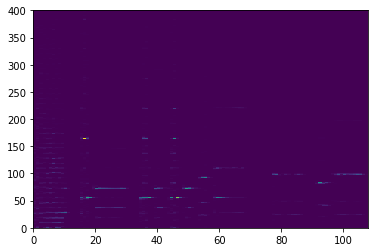

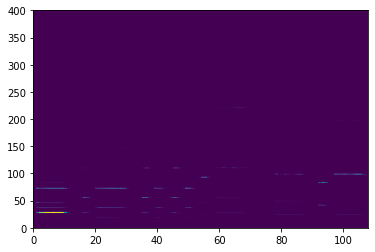

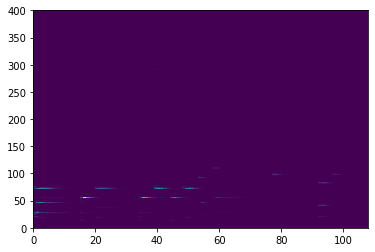

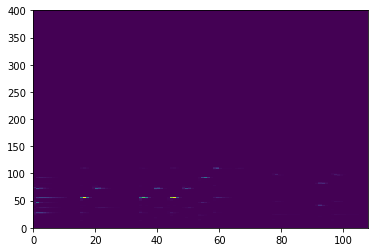

In [ ]:
spec = transforms.Spectrogram(n_fft=4095)
x_gram = spec(torch.from_numpy(train_X[0,0,:]))
piano_gram = spec(torch.from_numpy(train_Y[0,0,:]))
clarinet_gram = spec(torch.from_numpy(train_Y[0,1,:]))
guitar_gram = spec(torch.from_numpy(train_Y[0,2,:]))
plt.pcolormesh(x_gram[:400,:])
plt.show()
plt.pcolormesh(piano_gram[:400,:])
plt.show()
plt.pcolormesh(clarinet_gram[:400,:])
plt.show()
plt.pcolormesh(guitar_gram[:400,:])
plt.show()


In [ ]:
s = spectralEncoder(in_channels = 1, t = piano_gram.shape[1])
s.train()
p = np.expand_dims(piano_gram,axis = (0,1)).astype(np.float32)
print(p.shape)
s(torch.from_numpy(p)).shape

(1, 1, 2048, 108)


torch.Size([1, 3, 2048, 108])

train_data_x = np.array(num samples, 1 channel, audio signal)

train_data_Y = np.array(num samples, 3 instruments, audio signal)

In [ ]:
def train(model, n_epochs, batch_size, optimizer, loss_function, train_data_X, train_data_Y, val_data_X, val_data_Y):
  X = train_data_X[:,:,:]
  Y = train_data_Y[:,:,:]
  for epoch in range(n_epochs):
    print(epoch)
    for phase in ["train"]:
      loss = 0
      for i in range(0,X.shape[0], batch_size): #loop over num samples
        batch = X[i*batch_size:(i+1)*batch_size,:,:].astype(np.float32)
        batch = torch.from_numpy(batch).float().to(device)
        batch_spec = spec(batch)

        true_batch = Y[i*batch_size:(i+1)*batch_size,:,:].astype(np.float32)
        true_batch = torch.from_numpy(true_batch).float().to(device)
        true_batch_spec = spec(true_batch)
        if phase =="train":
          model.train()
        else:
          model.eval()
        optimizer.zero_grad()
        pred_batch = model(batch_spec) #Colab crashes here because not enough RAM, but I can run this line separately on Colab no problem.
        batch_loss = loss_function(pred_batch, true_batch_spec)
        if phase =="train":
          batch_loss.backward()
          optimizer.step()



In [ ]:
device = torch.device('cpu')
segnet = spectralEncoder(in_channels = train_X.shape[1], t = train_X.shape[2])
loss_fun = nn.MSELoss()
optimizer = torch.optim.Adam(segnet.parameters(), lr = 0.001)
train(model = segnet, n_epochs = 2, batch_size = 1, optimizer = optimizer, loss_function = loss_fun, train_data_X = train_X, train_data_Y = train_Y, val_data_X = None, val_data_Y = None)

0
(1, 1, 220500)
torch.Size([1, 1, 2048, 108])
torch.Size([1, 3, 2048, 108])
model train


In [ ]:
train_X.shape